In [125]:
import networkx as nx
import matplotlib.pyplot as plt

In [126]:
#All from other notebook
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

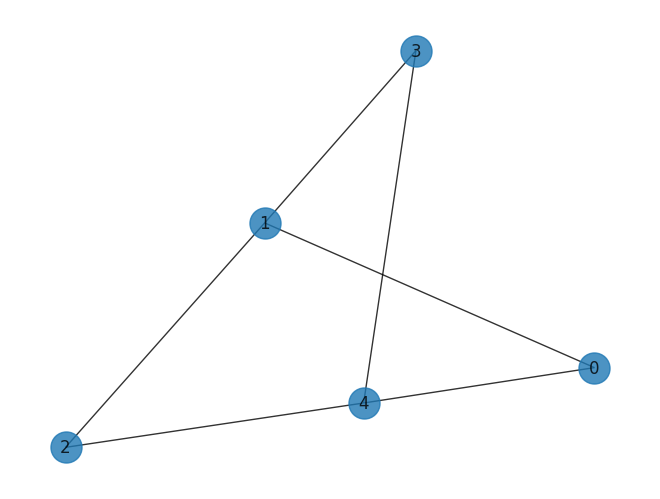

In [145]:
import networkx as nx
shotnum = 20000
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 4), (2, 1), (2,4), (3, 1), (3,4)])
#G.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
#G.add_edges_from([(0, 3), (0,1), (0,4), (1,4), (1,2), (4,2), (4,3), (4,5), (3,2),(3,6),(3,5),(2,5),(2,6),(6,5)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

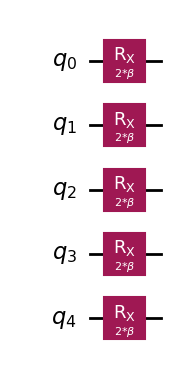

In [146]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = len(G.nodes)

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

(0, 1)
(0, 4)
(1, 2)
(1, 3)
(2, 4)
(3, 4)


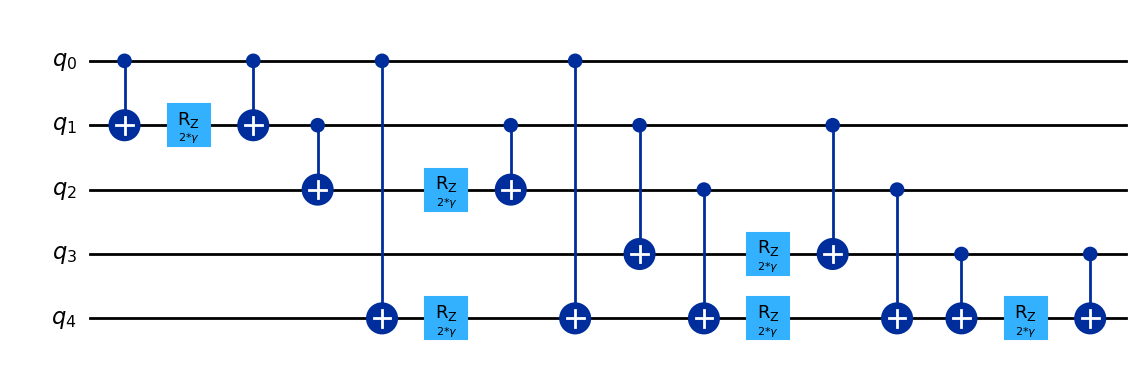

In [147]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    print(pair)
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    
qc_p.decompose().draw('mpl')


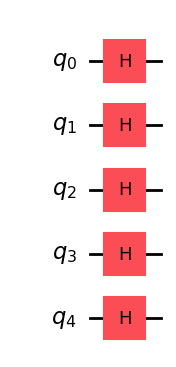

In [148]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

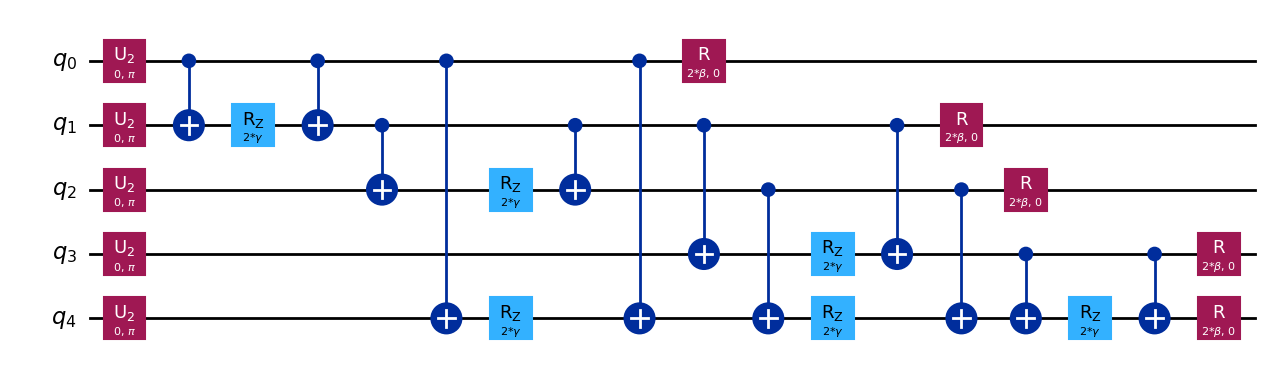

In [149]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [150]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
    return obj


def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    #print("returned: ", (avg/sum_count))
    return avg/sum_count

Bet = []
Gam = []
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta, appent = False):
    """
    Creates a parametrized qaoa circuit
    """
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    beta = theta[:p]
    gamma = theta[p:]
    #extra start
    if appent:
        Bet.append(beta)
        Gam.append(gamma)
    #gamma, beta = PIDControl(gamma, beta, Gam, Bet)
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    for irep in range(0, p):
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])
        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    qc.measure_all()
    return qc

def execute_circ(theta, appent = False):
    qc = create_qaoa_circ(G, theta, appent)
    counts = AerSimulator().run(qc, seed_simulator=10, shots=shotnum).result().get_counts()
    expec = compute_expectation(counts, G)
    return expec

def minimize(attemps, stepvalue = 1, multi = 2, damp = 2):
    beta = 1
    gamma = 1
    startval = stepvalue
    multiplier = multi
    stepb = startval
    stepg = startval
    for i in range((int)(attemps/6)):
        for i in range(2):
            forward = abs(execute_circ([beta+stepb, gamma]))
            middle = abs(execute_circ([beta, gamma], True))
            back = abs(execute_circ([beta-stepb, gamma]))
            if(forward + middle > middle + back): #checks if it should go forwards or backwards from 0.
                if(forward > middle):
                    beta = beta+stepb
                    stepb = stepb*multiplier
                else:
                    stepb = stepb/damp
            else:
                if(back > middle):
                    beta = beta-stepb
                    stepb = stepb*multiplier
                else:
                    stepb = stepb/damp
            print(forward, middle, back)
        for i in range(2):
            forward = abs(execute_circ([beta, gamma+stepg]))
            middle = abs(execute_circ([beta, gamma], True))
            back = abs(execute_circ([beta, gamma-stepg]))
            if(forward + middle > middle + back): #checks if it should go forwards or backwards from 0.
                if(forward > middle):
                    gamma = gamma+stepg
                    stepg = stepg*multiplier
                else:
                    stepg = stepg/damp
            else:
                if(back > middle):
                    beta = beta-stepg
                    stepg = stepg*multiplier
                else:
                    stepg = stepg/damp
        print(forward, middle, back)
    print(beta)
    print(gamma)
    return [beta, gamma]

    
    

3.32295 2.73095 2.99715
2.8578 3.32295 2.76215
2.98715 3.32295 1.7154
2.6608 3.32295 2.70515
2.84595 3.32295 2.952
3.07125 3.32295 2.7023
3.24615 3.32295 3.1629
2.7209 3.32295 2.66405
3.2459 3.32295 3.19215
2.70335 3.32295 2.7729
2.73625 3.32295 2.6753
3.31305 3.32295 3.29415
2.99515 3.32295 2.8898
2.6582 3.32295 2.6713
3.3232 3.32295 3.3076
2.8452 3.3232 2.75775
3.222 3.3232 3.2835
4.281 3.3232 3.24425
3.073 4.281 2.67725
1.7173 4.281 1.7373
2.65745 4.281 1.83475
2.2252 4.281 2.5642
3.056 4.281 3.4219
2.82075 4.281 2.98985
3.63185 4.281 3.9147
3.9353 4.281 4.1543
1.8719 4.281 2.82635
4.09925 4.281 4.2523
4.1771 4.281 4.2875
1.70875 4.2875 2.70525
2.67395 4.2875 2.39005
3.7613 4.2875 3.996
3.32125 4.2875 3.02145
4.0098 4.2875 4.17925
2.9305 4.2875 2.6258
2.9941 4.2875 2.8997
3.6176 4.2875 3.89155
1.7646 4.2875 1.9051
1.98255 4.2875 2.86835
2.1784 4.2875 1.9608
3.1282 4.2875 2.80615
2.9038 4.2875 3.01665
3.7726 4.2875 3.4721
4.0784 4.2875 3.85905
4.03855 4.2875 3.84685
4.21145 4.2875 4.

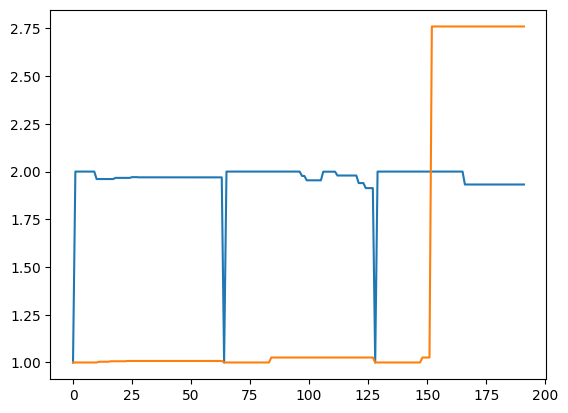

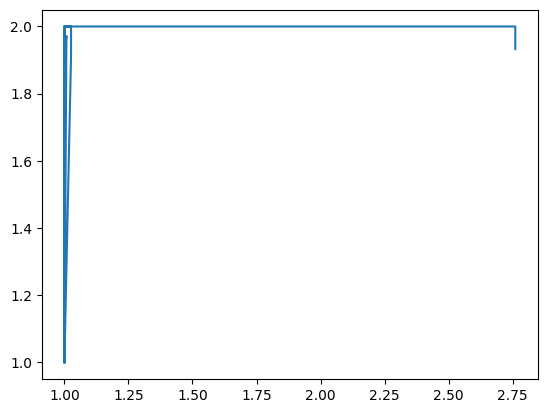

In [155]:
theta = minimize(100, 1, 100, 1.5)

Tim = range(len(Bet))
plt.plot(Tim, Bet)
plt.plot(Tim, Gam)
plt.show()
plt.plot(Gam, Bet)
plt.show()

{'00101': 585, '01100': 559, '10010': 4019, '11100': 636, '01011': 708, '00110': 664, '11000': 636, '01101': 3900, '10110': 591, '00111': 574, '00011': 658, '01010': 575, '10101': 615, '00001': 89, '10011': 598, '01001': 614, '11111': 180, '11110': 92, '00000': 152, '11001': 660, '11010': 595, '01111': 21, '00100': 98, '01110': 644, '10100': 596, '10001': 620, '01000': 85, '11011': 105, '10111': 84, '10000': 17, '00010': 18, '11101': 12}


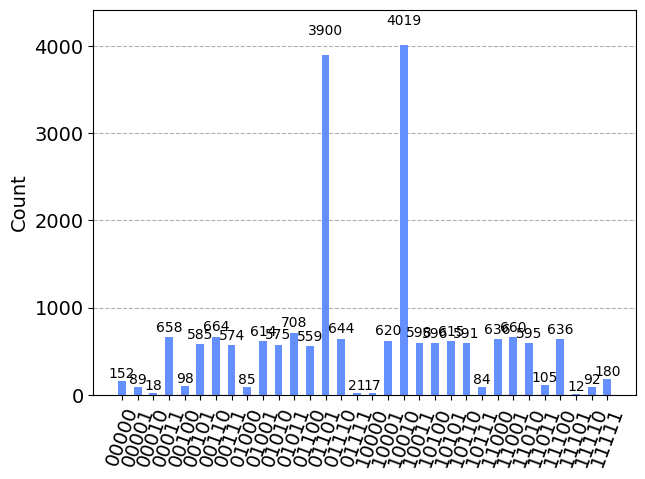

In [156]:
from qiskit.visualization import plot_histogram


qc_res = create_qaoa_circ(G, theta)

counts = AerSimulator().run(qc_res, seed_simulator=10, shots=shotnum).result().get_counts()
print(counts)
plot_histogram(counts)
